# Label propagation
Each organ expert group had used cellxgene to annotate celltypes from a cellxgene object. 
We read in the csv output by cellxgene (this required a little bit of manual engineering because the column names and numbers are not the same) 
Also skin was a last addition to the dataset, and is derived using a SS2 dataset rather than 10X, so the file names contain skin to differentiate it from previous versions of annotation.

# load necessary pacakges

In [1]:
import sys
import os 
homedir = '/home/ec2-user/'
sys.path.append(homedir + 'scVI/')
sys.path.append(homedir+'tabula-sapiens/')
import anndata

from scvi.dataset import AnnDatasetFromAnnData
from utils.annotations_utils import *
from anndata import read_h5ad
import scanpy as sc

from copy import deepcopy
retrain=False

import matplotlib
%matplotlib inline

# set and create directories for saving results

In [2]:
data_path = homedir + 'TabulaSapiensData/'
model_path = homedir + 'TabulaSapiens/scVImodels_final/'
res_path = homedir + 'TabulaSapiensData/combined/'
ann_path =  homedir + 'TabulaSapiensData/Pilot2/ManualAnnotation/'


if not os.path.exists(model_path):
    os.mkdir(model_path)
if not os.path.exists(model_path+'scanvi/'):
    os.mkdir(model_path+'scanvi/')
if not os.path.exists(res_path):
    os.mkdir(res_path)

# make annotation file for pilot2
This section of the notebook summarizes and concatenate the cellxgene output csv files and generate an annotation file 'Pilot2/pilot2.all.unique.skin.csv' for all Pilot2 datasets.

In [3]:
ann_files = os.listdir(ann_path)
print(ann_files)

['TSP2.muscle.Antoine.csv', 'TSP2.spleen.Kimberly.csv', 'TSP2.bladder.Aaron.csv', 'TSP2.thymus.Koki.csv', 'TSP2.vasculature.Ragini.csv', 'TSP2.lung.SoRi.csv', 'TSP2.skin.Kimberly.csv', 'TSP2.bm.MSwift.csv', 'hide', 'TSP2.blood.Sheela.csv', 'TSP2.trachea.William.csv', 'TSP2.li.Zhen.csv', 'TSP2.kidney.Gabe.csv', 'TSP2.lymphnode.Kimberly.csv', 'TSP2.all.unique.csv', 'TSP2.si.Zhen.csv']


In [4]:
pilot2_meta = pd.read_csv(data_path + 'Pilot2/pilot2.meta.csv', index_col=0)

In [5]:
annotations = {}
for x in ann_files:
    if 'csv' in x:
        print(x)
        organ = x.split('.')[1]
        if organ=='bm':
            tab = pd.read_csv(ann_path + x, index_col=0)
        else:
            tab = pd.read_csv(ann_path + x, index_col=0, skiprows=2)
        tab.index = [x.split('-')[0] for x in tab.index]
        if organ=='muscle':
            barcodes = tab.index
            unique_barcodes, count = np.unique(barcodes, return_counts=True)
            is_unique = [x in unique_barcodes[count==1] for x in barcodes]
            tab = tab.loc[is_unique]
        is_pilot2 = [x for x in tab.index if x in pilot2_meta.index]
        tab = tab.loc[is_pilot2]        
        tab = tab[[tab.columns[-1]]]
        tab.columns= ['manual_annotation']
        tab['organ'] = organ
        print(np.unique([len(x) for x in tab.index], return_counts=True))
        annotations[organ] = tab


TSP2.muscle.Antoine.csv
(array([16]), array([15689]))
TSP2.spleen.Kimberly.csv
(array([16]), array([7294]))
TSP2.bladder.Aaron.csv
(array([16]), array([10334]))
TSP2.thymus.Koki.csv
(array([16]), array([8035]))
TSP2.vasculature.Ragini.csv
(array([16]), array([7492]))
TSP2.lung.SoRi.csv
(array([16]), array([20605]))
TSP2.skin.Kimberly.csv
(array([78, 79, 80, 81, 82, 83, 84, 85, 86]), array([  4,  13,  27,  56,  70, 197, 190, 153, 146]))
TSP2.bm.MSwift.csv
(array([16]), array([2881]))
TSP2.blood.Sheela.csv
(array([16]), array([10177]))
TSP2.trachea.William.csv
(array([16]), array([4680]))
TSP2.li.Zhen.csv
(array([16]), array([7366]))
TSP2.kidney.Gabe.csv
(array([16]), array([22403]))
TSP2.lymphnode.Kimberly.csv
(array([16]), array([9110]))
TSP2.all.unique.csv
(array([16]), array([132103]))
TSP2.si.Zhen.csv
(array([16]), array([8203]))


In [6]:
ann = pd.concat([annotations[x] for x in annotations.keys() if x != 'all'], axis=0)
print(ann.shape)
barcodes = ann.index
unique_barcodes, count = np.unique(barcodes, return_counts=True)
ann = ann.loc[unique_barcodes[count==1]]
print(ann.shape)

(135125, 2)
(134547, 2)


In [7]:
ann.to_csv(data_path + 'Pilot2/pilot2.all.unique.skin.csv')

# Combining labels and unannotated filtered object
This section of the notebook matches the annotation file to unannoated combeind object from pilot1 and pilot2.

### read unannotated combined object

In [8]:
combined = read_h5ad(data_path + 'combined/Pilot1_Pilot2_filtered_ensembl_id.no_heart_fat_low_quality.june30.ss2_norm.embedding_donor_tech.h5ad')

### match 'Pilot1/pilot1.ann.csv' and 'Pilot2/pilot2.all.unique.skin.csv' to unannotated cells by their cell id. 

In [9]:
ann1 = pd.read_csv(data_path+'Pilot1/pilot1.ann.csv', index_col=0, dtype=str)

In [10]:
ann2 = combined.obs.loc[combined.obs['donor']=='TSP2']
ann2.index = [x.split('-')[0] for x in ann2.index]

In [11]:
unique = ann2.index.drop_duplicates(keep=False)
ann2 = ann2.loc[unique]

In [12]:
ann2_new = pd.read_csv(data_path + 'Pilot2/pilot2.all.unique.skin.csv', index_col=0, dtype=str)
ann2_new['Organ'] = [x[0].upper()+x[1:] for x in ann2_new['organ']]
ann2_new['Organ'].replace('Bm', 'Bone_Marrow', inplace=True)
ann2_new['Organ'].replace('Li', 'Large_Intestine', inplace=True)
ann2_new['Organ'].replace('Lymphnode', 'Lymph_Node', inplace=True)
ann2_new['Organ'].replace('Si','Small_Intestine', inplace=True)
ann2.index = [x+'_'+y for x,y in zip(ann2.index.values, ann2['tissue'])]
ann2_new.index = [x+'_'+y for x,y in zip(ann2_new.index.values, ann2_new['Organ'])]

In [13]:
ann2['manual_annotation'] = ann2_new.reindex(ann2.index)['manual_annotation']
ann2['manual_annotation'].fillna('unassigned',inplace=True)

In [14]:
ann1.index = ['_'.join(['TSP1',x]) for x in ann1.index]
ann2.index = ['_'.join(['TSP2',x,y]) for x,y in zip(ann2.index, ann2['sequencer'])]

In [15]:
idx1 = combined.obs.loc[combined.obs['donor']=='TSP1'].index
idx2 = combined.obs.loc[combined.obs['donor']=='TSP2'].index
seq2 = combined.obs.loc[combined.obs['donor']=='TSP2',['tissue','sequencer']].apply(lambda x:"_".join(x), axis=1)

idx1 = [x.split('-')[0] for x in idx1]
idx2 = [x.split('-')[0] for x in idx2]
idx1 = ['_'.join(['TSP1',x]) for x in idx1]
idx2 = ['_'.join(['TSP2',x,y]) for x,y in zip(idx2, seq2)]

assert len(idx1) == len(np.unique(idx1))
assert len(idx2) == len(np.unique(idx2))

### convert manual annotation terms to cell ontology terms using 'ontology/pilot2.manual2co.txt'

In [16]:
label_dict = pd.read_csv(data_path + 'ontology/pilot2.manual2co.txt', delimiter=';', index_col=0, dtype=str)
new_terms = pd.read_csv(data_path + 'ontology/new_terms.csv', delimiter='|', index_col=1, dtype=str)

labels1 = ann1.reindex(idx1)['Manual Annotation Round 2'].fillna('unassigned')
labels2 = ann2.reindex(idx2)['manual_annotation'].fillna('unassigned')
print(np.sum(labels1=='unassigned')/len(labels1),np.sum(labels2=='unassigned')/len(labels2))

labels = pd.concat([labels1, labels2])
labels = pd.DataFrame(labels)

0.4773788955013758 0.27238270982131


In [17]:
labels_clean = []
others = []
for x in labels[0]:
    if x=='unassigned':
        labels_clean.append(x)
    elif x not in label_dict.index:
        labels_clean.append(new_terms.loc[x, 'parent_name'])
        others.append(x)
    else:
        labels_clean.append(label_dict.loc[x,'cell_ontology_class'])

labels[1] = labels_clean

In [18]:
combined.obs['barcode']=''
combined.obs.loc[combined.obs['donor']=='TSP1', 'barcode'] = idx1
combined.obs.loc[combined.obs['donor']=='TSP2', 'barcode'] = idx2

combined.obs['manual_annotation'] = labels.loc[combined.obs['barcode'],0].values
combined.obs['manual_cell_ontology_class'] = labels.loc[combined.obs['barcode'],1].values


In [19]:
temp = [x.split('_')[1] for x in combined.obs['barcode']]
assert np.sum([x in y for x,y in zip(temp, combined.obs.index)]) == len(temp)

In [20]:
combined.obs.to_csv(data_path + 'Pilot1_Pilot2.annotation.csv')

# read dataset with manual annotation

In [21]:
combined = read_h5ad(data_path + 
                     'combined/Pilot1_Pilot2_filtered_ensembl_id.june30.ss2_norm.embedding_donor_tech.h5ad')

annotations = pd.read_csv(data_path + 'Pilot1_Pilot2.annotation.csv')

annotations.index = annotations['cell_id']

combined.obs['manual_cell_ontology_class'] = annotations.reindex(combined.obs['cell_id'])['manual_cell_ontology_class'].values
combined.obs['manual_annotation'] = annotations.reindex(combined.obs['cell_id'])['manual_annotation'].values
combined.obs['manual_annotation'].fillna('unassigned',inplace=True)
combined.obs['manual_cell_ontology_class'].fillna('unassigned',inplace=True)

# propagate labels per tissue

In [22]:
organs = np.unique(combined.obs['tissue'])

In [23]:
organs = [ x for x in organs if x not in ['Heart','Fat']]
print(organs)

['Bladder', 'Blood', 'Bone_Marrow', 'Kidney', 'Large_Intestine', 'Lung', 'Lymph_Node', 'Muscle', 'Pancreas', 'Skin', 'Small_Intestine', 'Spleen', 'Thymus', 'Trachea', 'Vasculature']


# train using per-organ scVI model
We subsample genes before training scVI to predict cell types

In [24]:
labels = pd.DataFrame(index=combined.obs.index, columns=['pred'])

In [25]:
retrain=False

Bladder


Trying to set attribute `.var` of view, copying.


[2020-07-16 19:30:14,740] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-16 19:30:14,742] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-16 19:30:16,169] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:30:16,388] INFO - scvi.dataset.dataset | Downsampled from 25751 to 25751 cells
[2020-07-16 19:30:16,712] INFO - scvi.dataset.dataset | Downsampling from 48944 to 23582 genes
[2020-07-16 19:30:18,388] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:30:18,606] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-16 19:30:20,015] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:30:20,232] INFO - scvi.dataset.dataset | Downsampled from 25751 to 25751 cells
[2020-07-16 19:30:20,234] INFO - scvi.dataset.dataset | extracting highly variable genes
[2020-07-16 19:30:52,247] INFO - scvi.dataset.dataset | Downsampling 

Trying to set attribute `.var` of view, copying.


[2020-07-16 19:30:58,415] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-16 19:30:58,417] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-16 19:30:59,233] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:30:59,363] INFO - scvi.dataset.dataset | Downsampled from 16017 to 16017 cells
[2020-07-16 19:30:59,555] INFO - scvi.dataset.dataset | Downsampling from 44444 to 18141 genes
[2020-07-16 19:31:00,507] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:31:00,638] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-16 19:31:01,443] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:31:01,572] INFO - scvi.dataset.dataset | Downsampled from 16017 to 16017 cells
[2020-07-16 19:31:01,572] INFO - scvi.dataset.dataset | extracting highly variable genes
[2020-07-16 19:31:20,934] INFO - scvi.dataset.dataset | Downsampling 

Trying to set attribute `.var` of view, copying.


['B cell' 'CD4-positive helper T cell'
 'CD4-positive, alpha-beta memory T cell'
 'CD8-positive, alpha-beta memory T cell' 'classical monocyte'
 'dendritic cell, human' 'effector memory CD8-positive, alpha-beta T cell'
 'erythrocyte' 'mast cell' 'megakaryocyte' 'memory B cell'
 'naive thymus-derived CD4-positive, alpha-beta T cell'
 'naive thymus-derived CD8-positive, alpha-beta T cell'
 'natural killer cell' 'neutrophil' 'non-classical monocyte' 'plasma cell'
 'platelet'] ['B cell' 'CD4-positive helper T cell'
 'CD4-positive, alpha-beta memory T cell'
 'CD8-positive, alpha-beta memory T cell' 'classical monocyte'
 'dendritic cell, human' 'effector memory CD8-positive, alpha-beta T cell'
 'erythrocyte' 'mast cell' 'megakaryocyte' 'memory B cell'
 'naive thymus-derived CD4-positive, alpha-beta T cell'
 'naive thymus-derived CD8-positive, alpha-beta T cell'
 'natural killer cell' 'neutrophil' 'non-classical monocyte' 'plasma cell'
 'platelet' 'unassigned']
Bone_Marrow
[2020-07-16 19:31:2

Trying to set attribute `.var` of view, copying.


[2020-07-16 19:31:35,376] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-16 19:31:35,377] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-16 19:31:36,146] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:31:36,277] INFO - scvi.dataset.dataset | Downsampled from 24236 to 24236 cells
[2020-07-16 19:31:36,474] INFO - scvi.dataset.dataset | Downsampling from 40789 to 23394 genes
[2020-07-16 19:31:37,389] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:31:37,521] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-16 19:31:38,287] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:31:38,418] INFO - scvi.dataset.dataset | Downsampled from 24236 to 24236 cells
[2020-07-16 19:31:38,419] INFO - scvi.dataset.dataset | extracting highly variable genes
[2020-07-16 19:32:01,149] INFO - scvi.dataset.dataset | Downsampling 

Trying to set attribute `.var` of view, copying.


['B cell' 'T cell' 'endothelial cell' 'kidney epithelial cell'
 'myeloid cell' 'natural killer cell' 'neutrophil'] ['B cell' 'T cell' 'endothelial cell' 'kidney epithelial cell'
 'myeloid cell' 'natural killer cell' 'neutrophil' 'unassigned']
Large_Intestine
[2020-07-16 19:32:03,370] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-16 19:32:03,372] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-16 19:32:03,649] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:32:03,696] INFO - scvi.dataset.dataset | Downsampled from 8193 to 8193 cells
[2020-07-16 19:32:03,766] INFO - scvi.dataset.dataset | Downsampling from 43757 to 26019 genes
[2020-07-16 19:32:04,096] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:32:04,146] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-16 19:32:04,421] INFO - scvi.dataset.dataset | Computing the library size for the new 

Trying to set attribute `.var` of view, copying.


[2020-07-16 19:32:20,282] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-16 19:32:20,285] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-16 19:32:22,618] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:32:22,970] INFO - scvi.dataset.dataset | Downsampled from 37162 to 37162 cells
[2020-07-16 19:32:23,491] INFO - scvi.dataset.dataset | Downsampling from 49183 to 25867 genes
[2020-07-16 19:32:26,236] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:32:26,591] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-16 19:32:28,912] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:32:29,270] INFO - scvi.dataset.dataset | Downsampled from 37162 to 37162 cells
[2020-07-16 19:32:29,271] INFO - scvi.dataset.dataset | extracting highly variable genes
[2020-07-16 19:33:18,068] INFO - scvi.dataset.dataset | Downsampling 

Trying to set attribute `.var` of view, copying.


[2020-07-16 19:33:23,010] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-16 19:33:23,012] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-16 19:33:23,418] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:33:23,485] INFO - scvi.dataset.dataset | Downsampled from 10064 to 10064 cells
[2020-07-16 19:33:23,584] INFO - scvi.dataset.dataset | Downsampling from 37774 to 24764 genes
[2020-07-16 19:33:24,065] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:33:24,133] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-16 19:33:24,537] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:33:24,605] INFO - scvi.dataset.dataset | Downsampled from 10064 to 10064 cells
[2020-07-16 19:33:24,605] INFO - scvi.dataset.dataset | extracting highly variable genes
[2020-07-16 19:33:39,037] INFO - scvi.dataset.dataset | Downsampling 

Trying to set attribute `.var` of view, copying.


[2020-07-16 19:33:41,868] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-16 19:33:41,869] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-16 19:33:43,039] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:33:43,209] INFO - scvi.dataset.dataset | Downsampled from 21731 to 21731 cells
[2020-07-16 19:33:43,462] INFO - scvi.dataset.dataset | Downsampling from 49349 to 24271 genes
[2020-07-16 19:33:44,829] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:33:44,997] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-16 19:33:46,140] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:33:46,306] INFO - scvi.dataset.dataset | Downsampled from 21731 to 21731 cells
[2020-07-16 19:33:46,308] INFO - scvi.dataset.dataset | extracting highly variable genes
[2020-07-16 19:34:18,557] INFO - scvi.dataset.dataset | Downsampling 

Trying to set attribute `.var` of view, copying.


[2020-07-16 19:34:21,469] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-16 19:34:21,470] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-16 19:34:22,025] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:34:22,110] INFO - scvi.dataset.dataset | Downsampled from 8893 to 8893 cells
[2020-07-16 19:34:22,231] INFO - scvi.dataset.dataset | Downsampling from 51464 to 29777 genes
[2020-07-16 19:34:22,883] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:34:22,970] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-16 19:34:23,521] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:34:23,605] INFO - scvi.dataset.dataset | Downsampled from 8893 to 8893 cells
[2020-07-16 19:34:23,606] INFO - scvi.dataset.dataset | extracting highly variable genes
[2020-07-16 19:34:41,109] INFO - scvi.dataset.dataset | Downsampling from

Trying to set attribute `.var` of view, copying.


['T cell' 'endothelial cell' 'macrophage' 'pancreatic A cell'
 'pancreatic D cell' 'pancreatic acinar cell' 'pancreatic ductal cell'
 'pancreatic stellate cell' 'type B pancreatic cell'] ['B cell' 'T cell' 'endothelial cell' 'macrophage' 'pancreatic A cell'
 'pancreatic D cell' 'pancreatic acinar cell' 'pancreatic ductal cell'
 'pancreatic stellate cell' 'type B pancreatic cell' 'unassigned']
Skin
[2020-07-16 19:34:42,035] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2020-07-16 19:34:42,317] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-16 19:34:42,318] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-16 19:34:42,723] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:34:42,789] INFO - scvi.dataset.dataset | Downsampled from 856 to 856 cells
[2020-07-16 19:34:42,870] INFO - scvi.dataset.dataset | Downsampling from 39804 to 39804 genes
[2020-07-16 19:34:43,304

Trying to set attribute `.var` of view, copying.


[2020-07-16 19:34:52,407] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-16 19:34:52,408] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-16 19:34:52,714] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:34:52,766] INFO - scvi.dataset.dataset | Downsampled from 9546 to 9546 cells
[2020-07-16 19:34:52,845] INFO - scvi.dataset.dataset | Downsampling from 46820 to 29378 genes
[2020-07-16 19:34:53,215] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:34:53,269] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-16 19:34:53,573] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:34:53,626] INFO - scvi.dataset.dataset | Downsampled from 9546 to 9546 cells
[2020-07-16 19:34:53,627] INFO - scvi.dataset.dataset | extracting highly variable genes
[2020-07-16 19:35:09,137] INFO - scvi.dataset.dataset | Downsampling from

Trying to set attribute `.var` of view, copying.


[2020-07-16 19:35:10,785] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-16 19:35:10,787] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-16 19:35:11,169] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:35:11,231] INFO - scvi.dataset.dataset | Downsampled from 8366 to 8366 cells
[2020-07-16 19:35:11,322] INFO - scvi.dataset.dataset | Downsampling from 41287 to 26387 genes
[2020-07-16 19:35:11,776] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:35:11,839] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-16 19:35:12,221] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:35:12,283] INFO - scvi.dataset.dataset | Downsampled from 8366 to 8366 cells
[2020-07-16 19:35:12,284] INFO - scvi.dataset.dataset | extracting highly variable genes
[2020-07-16 19:35:26,596] INFO - scvi.dataset.dataset | Downsampling from

Trying to set attribute `.var` of view, copying.


[2020-07-16 19:35:28,598] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-16 19:35:28,600] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-16 19:35:29,149] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:35:29,247] INFO - scvi.dataset.dataset | Downsampled from 12894 to 12894 cells
[2020-07-16 19:35:29,394] INFO - scvi.dataset.dataset | Downsampling from 44272 to 27012 genes
[2020-07-16 19:35:30,061] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:35:30,160] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-16 19:35:30,703] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:35:30,801] INFO - scvi.dataset.dataset | Downsampled from 12894 to 12894 cells
[2020-07-16 19:35:30,802] INFO - scvi.dataset.dataset | extracting highly variable genes
[2020-07-16 19:35:47,862] INFO - scvi.dataset.dataset | Downsampling 

Trying to set attribute `.var` of view, copying.


[2020-07-16 19:35:49,680] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-16 19:35:49,682] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-16 19:35:50,095] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:35:50,168] INFO - scvi.dataset.dataset | Downsampled from 8033 to 8033 cells
[2020-07-16 19:35:50,272] INFO - scvi.dataset.dataset | Downsampling from 35760 to 18968 genes
[2020-07-16 19:35:50,752] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:35:50,827] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-16 19:35:51,232] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:35:51,306] INFO - scvi.dataset.dataset | Downsampled from 8033 to 8033 cells
[2020-07-16 19:35:51,307] INFO - scvi.dataset.dataset | extracting highly variable genes
[2020-07-16 19:36:00,644] INFO - scvi.dataset.dataset | Downsampling from

Trying to set attribute `.var` of view, copying.


[2020-07-16 19:36:02,569] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-16 19:36:02,571] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-16 19:36:03,130] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:36:03,222] INFO - scvi.dataset.dataset | Downsampled from 8583 to 8583 cells
[2020-07-16 19:36:03,349] INFO - scvi.dataset.dataset | Downsampling from 36476 to 21058 genes
[2020-07-16 19:36:03,993] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:36:04,085] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-16 19:36:04,635] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-16 19:36:04,726] INFO - scvi.dataset.dataset | Downsampled from 8583 to 8583 cells
[2020-07-16 19:36:04,727] INFO - scvi.dataset.dataset | extracting highly variable genes
[2020-07-16 19:36:15,645] INFO - scvi.dataset.dataset | Downsampling from

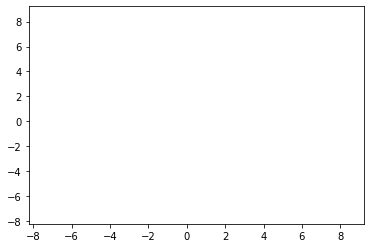

In [26]:
for organ in organs:
    print(organ)
    organ_data = combined[combined.obs['tissue']==organ]
    if organ=='Skin':
        organ_data = organ_data[organ_data.obs['method']=='smartseq2']
    organ_data = organ_data[organ_data.obs['manual_cell_ontology_class']!='low_quality']
    sc.pp.filter_genes(organ_data, min_cells=1)
    train_data = scVIdata_preprocess(organ_data, 'donor_tech', 'manual_cell_ontology_class')
    train_data.filter_genes_by_count(per_batch=True)
    if train_data.X.shape[0]>10000:
        train_data.subsample_genes(train_data.X.shape[0]//5)
    else:
        train_data.subsample_genes(train_data.X.shape[0]//2)
    posterior = get_scvi_posterior(train_data, 
                               model_path+'combined.%s.scVI.subsample_genes.pkl'%organ, 
                               retrain=retrain, n_epochs=100)


    full, pred_celltype = scanvi_pred(train_data, 
                                      model_path+'combined.%s.scVI.subsample_genes.pkl'%organ,
                                      model_path+'combined.%s.scANVI.subsample_genes.pkl'%organ,
                                      nlabels=30, retrain=retrain)

    pred_celltype = np.asarray([train_data.cell_types[x] for x in pred_celltype])
    assert np.sum(pred_celltype=='unassigned')==0
    labels.loc[organ_data.obs.index,'pred'] = pred_celltype
    print(np.unique(pred_celltype), train_data.cell_types)

In [27]:
labels['pred'].fillna('unassigned', inplace=True)

In [28]:
np.unique(combined.obs.loc[labels['pred']=='unassigned','tissue'])

array(['Kidney', 'Skin'], dtype=object)

In [29]:
np.sum(labels['pred']=='unassigned')

3

In [30]:
np.sum([x == 'low_quality' for x in combined.obs['manual_cell_ontology_class']])

1

In [31]:
np.sum([x in ['Fat', 'Heart', "Skin"] for x in combined.obs['tissue']])

858

In [32]:
combined.obs['propagated_cell_ontology_class'] = labels.loc[combined.obs.index, 'pred']

In [33]:
combined.obs.to_csv(data_path + 'combined/annotation.subsample_genes.csv')